In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

In [105]:
# data = pd.read_csv('data_preprocessed/data_combined_4000.csv', index_col='Unnamed: 0')
data = pd.read_csv('data_preprocessed/data_4513.csv', index_col='Unnamed: 0')
# data = data.loc[:2200, :]

In [106]:
X = data.drop(['Result', 'WeightClass', 'Gender', 'NumberOfRounds'], axis=1)
y = data['Result']

In [107]:
X

,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,RedWins,RedWinsBySubmission,RedCurrentWinStreak,RedLosses,RedCurrentLoseStreak,...,BlueAvgSigStrLanded,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct,BlueTotalRoundsFought,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO
0,34,165.10,170.18,125,1.0,12,4,6,3,0,...,0.00,0.000,0.00,0.00,0.000,0,6,2,0,0
1,30,185.42,195.58,170,1.0,6,5,6,0,0,...,5.50,0.550,0.30,0.77,0.550,20,0,1,5,3
2,34,193.04,205.74,245,1.0,9,2,1,2,0,...,5.13,0.570,0.20,0.45,0.630,44,3,4,5,6
3,30,177.80,177.80,145,0.0,7,1,0,2,1,...,3.74,0.440,0.50,0.47,0.250,7,6,0,0,0
4,36,175.26,182.88,145,1.0,5,2,1,3,0,...,4.41,0.530,0.80,0.75,0.370,15,2,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6512,24,182.88,193.04,170,0.0,6,5,0,3,1,...,4.00,0.275,0.00,0.00,0.000,2,1,0,0,1
6518,26,193.04,195.58,238,1.0,4,0,4,0,0,...,13.70,0.548,0.70,1.20,0.572,16,0,4,0,5
6521,28,170.18,177.80,155,1.0,5,1,0,5,2,...,10.75,0.333,1.25,1.25,0.663,7,3,1,0,0
6523,31,177.80,177.80,170,1.0,2,0,0,1,1,...,0.00,0.000,0.00,0.00,0.000,0,1,1,0,0


In [16]:
# # Отображение первых двух признаков
# plt.scatter(X.values[:, 4], X.values[:, 12], c=y)
# plt.xlabel('Признак 1')
# plt.ylabel('Признак 2')
# plt.title('Сгенерированные данные')
# plt.show()

In [108]:
test_size = int(len(X)*0.25)

X_train = X.iloc[test_size:, :]
y_train = y.iloc[test_size:]
X_test = X.iloc[:test_size, :]
y_test = y.iloc[:test_size]

In [109]:
scaler = StandardScaler().set_output(transform='pandas')
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [110]:
X_train

,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,RedWins,RedWinsBySubmission,RedCurrentWinStreak,RedLosses,RedCurrentLoseStreak,...,BlueAvgSigStrLanded,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct,BlueTotalRoundsFought,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO
1131,-1.902484,-2.180086,-1.971176,-1.342055,0.493992,-0.750928,-0.566613,-0.074916,-0.889675,-0.667484,...,0.091568,1.031730,-0.476063,0.705085,0.964635,0.275064,-0.392680,-0.690759,0.916870,-0.577911
1132,0.432085,0.278306,0.034458,-0.236831,0.493992,-0.965199,-0.566613,-0.622631,-0.522771,0.547265,...,0.635741,0.276585,-0.315357,-0.597620,0.291126,-0.577909,-0.825933,-0.690759,-0.141839,-0.577911
1133,-1.202113,-1.087468,-0.856935,-1.065749,-2.024325,-0.536658,0.631005,-0.622631,0.211038,0.547265,...,-0.301102,0.606961,1.130996,1.154828,0.647690,0.985874,-0.825933,-0.690759,-0.141839,-0.031173
1134,-0.034829,-1.360622,-0.634087,-0.789443,0.493992,0.106154,-0.566613,0.472798,-0.155866,-0.667484,...,0.499698,0.842944,-0.315357,0.550001,0.568454,-0.364666,0.040573,0.640295,-0.141839,-0.577911
1135,-0.268286,-0.268004,-0.411239,-0.236831,0.493992,-0.750928,-0.566613,-0.622631,-0.522771,0.547265,...,0.465687,0.559764,-0.636769,-0.768212,-1.016274,-0.720071,-0.392680,-0.690759,-0.671193,-0.577911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6512,-1.435570,0.551461,0.925851,0.177628,-2.024325,0.320425,2.427432,-0.622631,0.211038,0.547265,...,0.060649,-0.360569,-0.636769,-0.768212,-1.016274,-0.648990,-0.392680,-0.690759,-0.671193,-0.031173
6518,-0.968657,1.644079,1.148699,2.056508,0.493992,-0.108116,-0.566613,1.568227,-0.889675,-0.667484,...,3.059784,0.927898,0.488172,0.162291,1.249886,0.346145,-0.825933,1.083980,-0.671193,2.155780
6521,-0.501743,-0.814313,-0.411239,-0.236831,0.493992,0.106154,0.032196,-0.622631,0.944846,1.762013,...,2.147676,-0.086829,1.372055,0.201062,1.610412,-0.293585,0.473826,-0.247074,-0.671193,-0.577911
6523,0.198628,0.005151,-0.411239,0.177628,0.493992,-0.536658,-0.566613,-0.622631,-0.522771,0.547265,...,-1.176107,-1.658476,-0.636769,-0.768212,-1.016274,-0.791152,-0.392680,-0.247074,-0.671193,-0.577911


In [7]:
# Определение датасета
class FighterDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X.iloc[idx]
        y = self.y.iloc[idx]  # берем только первый столбец (класс)
        return {
            'x': torch.tensor(x, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.long)
        }  

### Базовая модель. 3 слоя

In [46]:
# Определение нейронной сети
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(36, 128)  # входной слой
        self.fc2 = nn.Linear(128, 64)  # скрытый слой
        self.fc3 = nn.Linear(64, 2)  # выходной слой 

        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)              

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # активация ReLU
        x = torch.relu(self.fc2(x))  # активация ReLU
        x = self.fc3(x)
        return x      

### Больше слоев

In [24]:
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(36, 128)  # входной слой
        self.fc2 = nn.Linear(128, 64)  # скрытый слой
        self.fc3 = nn.Linear(64, 32)  # скрытый слой
        self.fc4 = nn.Linear(32, 2)  # выходной слой

        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight) 
        nn.init.kaiming_normal_(self.fc3.weight) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # активация ReLU
        x = torch.relu(self.fc2(x))  # активация ReLU
        x = torch.relu(self.fc3(x))  # активация ReLU
        x = self.fc4(x)
        return x

### Добавляем дропаут

In [38]:
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(36, 128)  # входной слой
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(128, 128)  # скрытый слой
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(128, 64)  # скрытый слой
        self.dropout3 = nn.Dropout(p=0.2)
        self.fc4 = nn.Linear(64, 64)  # скрытый слой
        self.dropout4 = nn.Dropout(p=0.2)
        self.fc5 = nn.Linear(64, 32)  # скрытый слой
        self.dropout5 = nn.Dropout(p=0.2)
        self.fc6 = nn.Linear(32, 2)  # выходной слой   

    def forward(self, x):        
        x = torch.relu(self.fc1(x))  # активация ReLU
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))  # активация ReLU
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))  # активация ReLU
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))  # активация ReLU
        x = self.dropout4(x)
        x = torch.relu(self.fc5(x))  # активация ReLU
        x = self.dropout5(x)
        x = self.fc6(x)
        return x

### Разные функции активации

In [63]:
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(18, 128)  # входной слой
        self.fc2 = nn.Linear(128, 64)  # скрытый слой
        self.fc3 = nn.Linear(64, 2)  # выходной слой

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # функция активации sigmoid
        x = torch.sigmoid(self.fc2(x))  # функция активации sigmoid
        x = self.fc3(x)
        return x

### Тестируем модель

In [47]:
# Загрузка данных
X = X_train
y = y_train

# Создание датасета и даталоадера
# Создание датасета и даталоадера
train_dataset = FighterDataset(X_train, y_train)
test_dataset = FighterDataset(X_test, y_test)
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Инициализация нейронной сети и оптимизатора
net = FighterNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.016)

# Обучение нейронной сети
for epoch in range(100):
    for batch in train_dataloader:
        x = batch['x']
        y = batch['y']
        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    print(f'Эпоха {epoch+1}, потеря: {loss.item()}')

Эпоха 1, потеря: 0.6585376262664795
Эпоха 2, потеря: 0.8528990149497986
Эпоха 3, потеря: 0.5933067798614502
Эпоха 4, потеря: 0.7117568254470825
Эпоха 5, потеря: 0.6482813358306885
Эпоха 6, потеря: 0.6012226343154907
Эпоха 7, потеря: 0.5678257346153259
Эпоха 8, потеря: 0.8110523223876953
Эпоха 9, потеря: 0.6591725945472717
Эпоха 10, потеря: 0.5936846733093262
Эпоха 11, потеря: 0.511448085308075
Эпоха 12, потеря: 0.6898741722106934
Эпоха 13, потеря: 0.45960739254951477
Эпоха 14, потеря: 0.6844168305397034
Эпоха 15, потеря: 0.6160289645195007
Эпоха 16, потеря: 0.45250093936920166
Эпоха 17, потеря: 0.5801339745521545
Эпоха 18, потеря: 0.6423971056938171
Эпоха 19, потеря: 0.7835880517959595
Эпоха 20, потеря: 0.5919695496559143
Эпоха 21, потеря: 0.5960819125175476
Эпоха 22, потеря: 0.45870983600616455
Эпоха 23, потеря: 0.5810636281967163
Эпоха 24, потеря: 0.4795527756214142
Эпоха 25, потеря: 0.503419041633606
Эпоха 26, потеря: 0.5621406435966492
Эпоха 27, потеря: 0.45910704135894775
Эпоха 28

f1_score: 0.506
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.89      0.70       635
           1       0.53      0.17      0.26       493

    accuracy                           0.57      1128
   macro avg       0.56      0.53      0.48      1128
weighted avg       0.56      0.57      0.51      1128



Text(0.5, 23.52222222222222, 'predicted value')

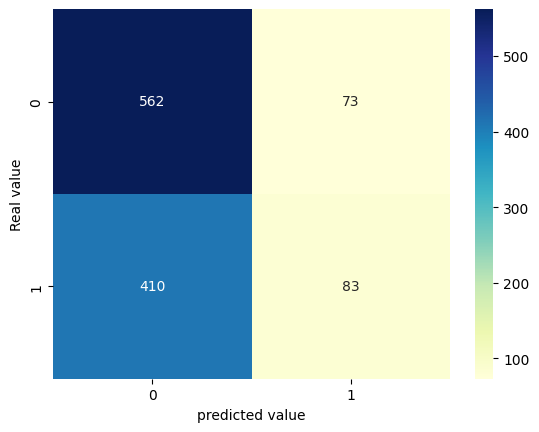

In [48]:
# Оценка модели на тестовых данных
net.eval()
test_y_pred_proba = []
test_y_true = []
test_y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x']
        y = batch['y']
        outputs = net(x)
        _, predicted = torch.max(outputs, 1)
        test_y_pred.extend(predicted.cpu().numpy())
        y_pred_proba = torch.nn.functional.softmax(outputs, dim=1)
        test_y_pred_proba.extend(y_pred_proba.cpu().numpy())
        test_y_true.extend(y.cpu().numpy())

# Матрица ошибок
print(f'f1_score: {f1_score(test_y_true, test_y_pred, average='weighted'):.3f}')
test_y_pred = np.argmax(test_y_pred_proba, axis=1)
test_cm = confusion_matrix(test_y_true, test_y_pred)
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(test_y_true, test_y_pred))


sns.heatmap(test_cm,  annot=True, fmt='d', cmap='YlGnBu')
plt.ylabel('Real value')
plt.xlabel('predicted value')

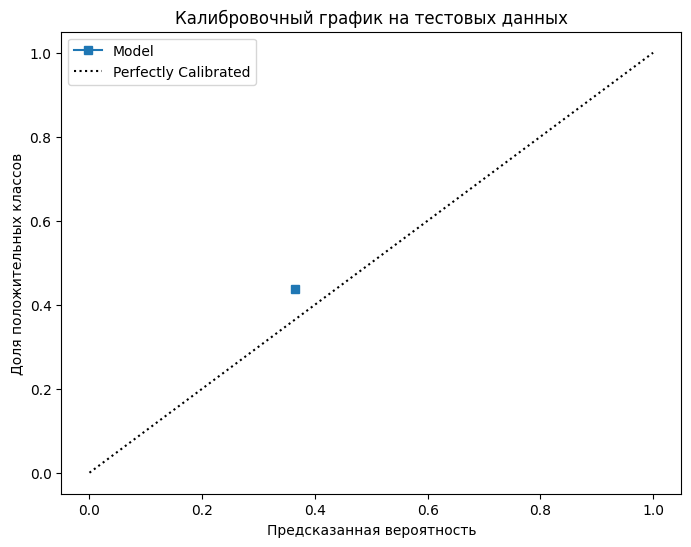

In [43]:
# Калибровочный график
plt.figure(figsize=(8, 6))
test_y_pred_proba_array = np.array(test_y_pred_proba)
fraction_of_positives, mean_predicted_value = calibration_curve(test_y_true, test_y_pred_proba_array[:, 1], n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives,'s-', label='Model')
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly Calibrated')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Доля положительных классов')
plt.title('Калибровочный график на тестовых данных')
plt.legend()
plt.show()

### Label Smoothing

In [80]:
# Определение функции потерь с label smoothing
class LabelSmoothingLoss(nn.Module):
    def __init__(self, alpha=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.alpha = alpha

    def forward(self, inputs, targets):
        n_classes = inputs.size(1)
        one_hot_targets = torch.zeros_like(inputs)
        one_hot_targets.scatter_(1, targets.long().unsqueeze(1), 1)
        smoothed_targets = (1 - self.alpha) * one_hot_targets + self.alpha / n_classes
        loss = nn.KLDivLoss()(inputs, smoothed_targets)
        return loss

In [73]:
net = FighterNet()
criterion = LabelSmoothingLoss(alpha=0.01)

# Обучение нейронной сети
for epoch in range(20):
    for batch in train_dataloader:
        x = batch['x']
        y = batch['y']
        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    print(f'Эпоха {epoch+1}, потеря: {loss.item()}')

Эпоха 1, потеря: 0.025843452662229538
Эпоха 2, потеря: -0.054635897278785706
Эпоха 3, потеря: -0.04284726083278656
Эпоха 4, потеря: 0.0019784176256507635
Эпоха 5, потеря: 0.10140697658061981
Эпоха 6, потеря: -0.11679397523403168
Эпоха 7, потеря: 0.05460936948657036
Эпоха 8, потеря: -0.010708310641348362
Эпоха 9, потеря: 0.01668395847082138
Эпоха 10, потеря: 0.08795835822820663
Эпоха 11, потеря: -0.005276360549032688
Эпоха 12, потеря: -0.06129812076687813
Эпоха 13, потеря: 0.025799503549933434
Эпоха 14, потеря: 0.0232058335095644
Эпоха 15, потеря: 0.007699806708842516
Эпоха 16, потеря: -0.15032294392585754
Эпоха 17, потеря: 0.04614995792508125
Эпоха 18, потеря: 0.05559267848730087
Эпоха 19, потеря: 0.024334631860256195
Эпоха 20, потеря: -0.07305824011564255


f1_score: 0.475
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.86      0.68       635
           1       0.44      0.14      0.21       493

    accuracy                           0.55      1128
   macro avg       0.50      0.50      0.45      1128
weighted avg       0.51      0.55      0.47      1128



Text(0.5, 23.52222222222222, 'predicted value')

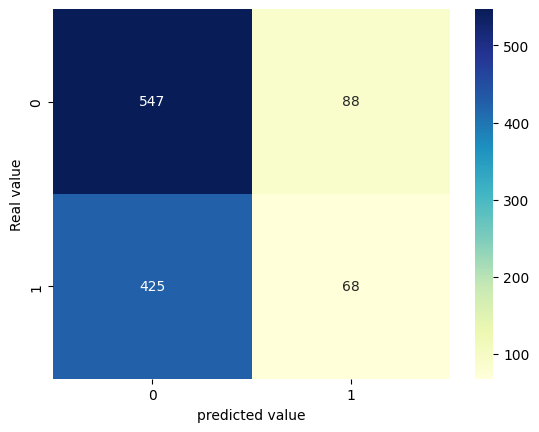

In [74]:
# Оценка модели на тестовых данных
net.eval()
test_y_pred_proba = []
test_y_true = []
test_y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x']
        y = batch['y']
        outputs = net(x)
        _, predicted = torch.max(outputs, 1)
        test_y_pred.extend(predicted.cpu().numpy())
        y_pred_proba = torch.nn.functional.softmax(outputs, dim=1)
        test_y_pred_proba.extend(y_pred_proba.cpu().numpy())
        test_y_true.extend(y.cpu().numpy())

# Матрица ошибок
print(f'f1_score: {f1_score(test_y_true, test_y_pred, average='weighted'):.3f}')
test_y_pred = np.argmax(test_y_pred_proba, axis=1)
test_cm = confusion_matrix(test_y_true, test_y_pred)
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(test_y_true, test_y_pred))


sns.heatmap(test_cm,  annot=True, fmt='d', cmap='YlGnBu')
plt.ylabel('Real value')
plt.xlabel('predicted value')

### Сиамская сеть

In [49]:
train_dataset = FighterDataset(X_train, y_train)
test_dataset = FighterDataset(X_test, y_test)
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [67]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(36, 128)  # Измените 38 на 20
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x1, x2):
        x1 = torch.relu(self.fc1(x1))
        x1 = torch.relu(self.fc2(x1))
        x1 = self.fc3(x1)

        x2 = torch.relu(self.fc1(x2))
        x2 = torch.relu(self.fc2(x2))
        x2 = self.fc3(x2)

        outputs = torch.sigmoid(x1 - x2)
        return outputs

In [68]:
# Обучение сиамской нейросети
model = SiameseNetwork()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

for epoch in range(3):
    for batch in train_dataloader:
        x = batch['x']
        y = batch['y']
        optimizer.zero_grad()
        mid = len(x) // 2
        x1 = x[:mid]
        x2 = x[mid:mid + mid]
        outputs = model(x1, x2)
        loss = criterion(outputs, y[:mid].view(-1, 1).float())
        loss.backward()
        optimizer.step()
        print(f'Эпоха {epoch+1}, потеря: {loss.item()}') 

# Оценка сиамской нейросети
y_pred = []
for batch in test_dataloader:
    x = batch['x']
    output = model(x, x)  # используйте каждое входное данные как пару
    y_pred.extend((output > 0.5).int().cpu().numpy())

print(f'Точность: {accuracy_score(y_test, y_pred)}')
print(f'Полнота: {precision_score(y_test, y_pred)}')
print(f'Полнота: {recall_score(y_test, y_pred)}')
print(f'F1-мера: {f1_score(y_test, y_pred)}')

Эпоха 1, потеря: 0.8167619109153748
Эпоха 1, потеря: 0.7900108098983765
Эпоха 1, потеря: 0.7144498825073242
Эпоха 1, потеря: 0.8257088661193848
Эпоха 1, потеря: 0.7532044053077698
Эпоха 1, потеря: 0.8932039737701416
Эпоха 1, потеря: 0.9794616103172302
Эпоха 1, потеря: 0.6819758415222168
Эпоха 1, потеря: 0.9944759607315063
Эпоха 1, потеря: 0.8069759607315063
Эпоха 1, потеря: 0.8631901144981384
Эпоха 1, потеря: 0.9169616103172302
Эпоха 1, потеря: 0.5807187557220459
Эпоха 1, потеря: 0.7057187557220459
Эпоха 1, потеря: 0.7057187557220459
Эпоха 1, потеря: 0.8006900548934937
Эпоха 1, потеря: 0.7294616103172302
Эпоха 1, потеря: 0.9019472599029541
Эпоха 1, потеря: 0.8307188153266907
Эпоха 1, потеря: 0.8544615507125854
Эпоха 1, потеря: 0.7919615507125854
Эпоха 1, потеря: 0.8782044053077698
Эпоха 1, потеря: 0.8244329690933228
Эпоха 1, потеря: 0.7144472599029541
Эпоха 1, потеря: 0.7769472599029541
Эпоха 1, потеря: 0.7231758236885071
Эпоха 1, потеря: 0.9407044053077698
Эпоха 1, потеря: 0.777005672

### Эмбеддинг-нейросеть + Предсказательная нейросеть

In [69]:
# Инициализация моделей
class EmbeddingNetwork(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(EmbeddingNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, embedding_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class PredictionNetwork(nn.Module):
    def __init__(self, embedding_dim):
        super(PredictionNetwork, self).__init__()
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Инициализация моделей
embedding_network = EmbeddingNetwork(input_dim=18, embedding_dim=180)
prediction_network = PredictionNetwork(embedding_dim=180)

# Определение функции потерь и оптимизатора
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(list(embedding_network.parameters()) + list(prediction_network.parameters()), lr=0.001)

# Обучение моделей
for epoch in range(60):
    for batch in train_dataloader:
        x = batch['x']
        y = batch['y']

        # Разделение входных данных на пары бойцов
        x1 = x[:, :18]
        x2 = x[:, 18:]

        # Получение эмбеддингов
        embedding1 = embedding_network(x1)
        embedding2 = embedding_network(x2)

        # Предсказание
        outputs = prediction_network(embedding1, embedding2)

        # Расчет потерь
        loss = criterion(outputs, y.view(-1, 1).float())

        # Обратное распространение ошибок
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Эпоха {epoch+1}, потеря: {loss.item()}')

In [71]:
# Оценка модели на тестовой выборке
embedding_network.eval()
prediction_network.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x']
        y = batch['y']

        # Разделение входных данных на пары бойцов
        x1 = x[:, :18]
        x2 = x[:, 18:]

        # Получение эмбеддингов
        embedding1 = embedding_network(x1)
        embedding2 = embedding_network(x2)

        # Предсказание
        outputs = prediction_network(embedding1, embedding2)

        # Преобразование выходных данных в бинарные метки
        pred = torch.sigmoid(outputs) > 0.5
        y_pred.extend(pred.int().cpu().numpy())
        y_true.extend(y.int().cpu().numpy())

# Расчет F1-меры
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print(f'F1-мера: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

F1-мера: 0.5010
Accuracy: 0.5479
Precision: 0.4839
Recall: 0.5193


### Сиамская сеть + Label Smoothing

In [97]:
# Инициализация моделей
embedding_network = EmbeddingNetwork(input_dim=18, embedding_dim=180)
prediction_network = PredictionNetwork(embedding_dim=180)

class LabelSmoothingLoss(nn.Module):
    def __init__(self, alpha=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.alpha = alpha

    def forward(self, inputs, targets):
        n_classes = 2
        targets = targets.long()
        one_hot_targets = torch.zeros(targets.shape[0], n_classes, device=targets.device)
        one_hot_targets[range(targets.shape[0]), targets] = 1
        smoothed_targets = (1 - self.alpha) * one_hot_targets + self.alpha / n_classes
        inputs = torch.sigmoid(inputs)
        inputs = torch.cat((1 - inputs, inputs), dim=1)
        loss = nn.KLDivLoss()(inputs, smoothed_targets)
        return loss

criterion = LabelSmoothingLoss(alpha=0.01)
optimizer = optim.Adam(list(embedding_network.parameters()) + list(prediction_network.parameters()), lr=0.001)

# Обучение моделей
for epoch in range(40):
    for batch in train_dataloader:
        x = batch['x']
        y = batch['y']

        # Разделение входных данных на пары бойцов
        x1 = x[:, :18]
        x2 = x[:, 18:]

        # Получение эмбеддингов
        embedding1 = embedding_network(x1)
        embedding2 = embedding_network(x2)

        # Предсказание
        outputs = prediction_network(embedding1, embedding2)

        # Расчет потерь
        loss = criterion(outputs, y)

        # Обратное распространение ошибок
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Эпоха {epoch+1}, потеря: {loss.item()}')

Эпоха 1, потеря: -0.2955140471458435
Эпоха 2, потеря: -0.3944286108016968
Эпоха 3, потеря: -0.21625573933124542
Эпоха 4, потеря: -0.255866140127182
Эпоха 5, потеря: -0.3944242000579834
Эпоха 6, потеря: -0.3151056170463562
Эпоха 7, потеря: -0.33488619327545166
Эпоха 8, потеря: -0.3551925718784332
Эпоха 9, потеря: -0.2360394150018692
Эпоха 10, потеря: -0.29544007778167725
Эпоха 11, потеря: -0.2360389530658722
Эпоха 12, потеря: -0.37462204694747925
Эпоха 13, потеря: -0.2756352722644806
Эпоха 14, потеря: -0.28766942024230957
Эпоха 15, потеря: -0.3152395188808441
Эпоха 16, потеря: -0.27514946460723877
Эпоха 17, потеря: -0.3349788784980774
Эпоха 18, потеря: -0.379578560590744
Эпоха 19, потеря: -0.354839563369751
Эпоха 20, потеря: -0.24373218417167664
Эпоха 21, потеря: -0.37463855743408203
Эпоха 22, потеря: -0.3350812792778015
Эпоха 23, потеря: -0.39604443311691284
Эпоха 24, потеря: -0.3491295874118805
Эпоха 25, потеря: -0.31766316294670105
Эпоха 26, потеря: -0.3935811519622803
Эпоха 27, поте

In [98]:
# Оценка модели на тестовой выборке
embedding_network.eval()
prediction_network.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x']
        y = batch['y']

        # Разделение входных данных на пары бойцов
        x1 = x[:, :18]
        x2 = x[:, 18:]

        # Получение эмбеддингов
        embedding1 = embedding_network(x1)
        embedding2 = embedding_network(x2)

        # Предсказание
        outputs = prediction_network(embedding1, embedding2)

        # Преобразование выходных данных в бинарные метки
        pred = torch.sigmoid(outputs) > 0.5
        y_pred.extend(pred.int().cpu().numpy())
        y_true.extend(y.int().cpu().numpy())

# Расчет F1-меры
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print(f'F1-мера: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

F1-мера: 0.3795
Accuracy: 0.6028
Precision: 0.5983
Recall: 0.2779


### RNN

In [58]:
class MMADataSet(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MMADataSet(X_train, y_train)
test_dataset = MMADataSet(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Базовая RNN

In [15]:
# Модель RNN
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x.unsqueeze(1), h0)
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

### Больше слоев

In [97]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)  # добавить размерность 1 для длины последовательности
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        c0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return torch.sigmoid(out)

### Еще больше слоев

In [99]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn1 = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.rnn2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.rnn1.num_layers, x.size(0), self.rnn1.hidden_size).to(x.device)
        c0 = torch.zeros(self.rnn1.num_layers, x.size(0), self.rnn1.hidden_size).to(x.device)
        out, _ = self.rnn1(x, (h0, c0))
        h1 = torch.zeros(self.rnn2.num_layers, out.size(0), self.rnn2.hidden_size).to(x.device)
        c1 = torch.zeros(self.rnn2.num_layers, out.size(0), self.rnn2.hidden_size).to(x.device)
        out, _ = self.rnn2(out, (h1, c1))
        out = out[:, -1, :]
        out = self.dropout1(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout2(out)
        out = torch.relu(self.fc2(out))
        out = self.dropout3(out)
        out = self.fc3(out)
        return torch.sigmoid(out)

In [ ]:
model = RNNModel(input_dim=X_train.shape[1], hidden_dim=128, output_dim=1)

# Обучение модели
criterion = nn.BCELoss()
optimizer = optim.Rprop(model.parameters(), lr=0.01)

for epoch in range(16):
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Оценка модели
model.eval()
with torch.no_grad():
    total_correct = 0
    predicted_labels = []
    test_labels = []
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        predicted_labels.extend(predicted.numpy().flatten())
        test_labels.extend(labels.numpy().flatten())

# Преобразовать списки в numpy массивы
predicted_labels = np.array(predicted_labels)
test_labels = np.array(test_labels)

# Матрица ошибок
conf_mat = confusion_matrix(test_labels, predicted_labels)
print("Матрица ошибок:")
sns.heatmap(conf_mat,  annot=True, fmt='d', cmap='YlGnBu')
plt.ylabel('Real value')
plt.xlabel('predicted value')

# Classification report
print("\nClassification report:")
report = classification_report(test_labels, predicted_labels, output_dict=True)
print(report)

### Меняем количество нейронов в слое

In [17]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn1 = nn.LSTM(input_dim, 64, num_layers=2, batch_first=True)
        self.rnn2 = nn.LSTM(64, 32, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.rnn1.num_layers, x.size(0), self.rnn1.hidden_size).to(x.device)
        c0 = torch.zeros(self.rnn1.num_layers, x.size(0), self.rnn1.hidden_size).to(x.device)
        out, _ = self.rnn1(x, (h0, c0))
        h1 = torch.zeros(self.rnn2.num_layers, out.size(0), self.rnn2.hidden_size).to(x.device)
        c1 = torch.zeros(self.rnn2.num_layers, out.size(0), self.rnn2.hidden_size).to(x.device)
        out, _ = self.rnn2(out, (h1, c1))
        out = out[:, -1, :]
        out = self.dropout1(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout2(out)
        out = torch.relu(self.fc2(out))
        out = self.dropout3(out)
        out = self.fc3(out)
        return torch.sigmoid(out)

In [ ]:
# Определение модели
import torch.optim.rprop


model = RNNModel(input_dim=39, output_dim=2)

# Определение функции потерь и оптимизатора
criterion = nn.BCELoss()
optimizer = torch.optim.Rprop(model.parameters(), lr=0.01)

# Обучение модели
for epoch in range(15):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        labels = labels[:, None]  # добавляем новый размерность
        labels = torch.cat((1 - labels, labels), dim=1)  # преобразуем в бинарный формат
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # print(f'Эпоха {epoch+1}, потеря: {total_loss / len(train_loader)}')

# Оценка модели на тестовой выборке
model.eval()
test_loss = 0
correct = 0
predicted_labels = []
test_labels = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        labels = labels[:, None]  # добавляем новый размерность
        labels = torch.cat((1 - labels, labels), dim=1)  # преобразуем в бинарный формат
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)  # получаем индекс максимальной вероятности
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
        predicted_labels.extend(predicted.cpu().numpy())
        test_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())

# Матрица ошибок
conf_mat = confusion_matrix(test_labels, predicted_labels)
print(f'f1_score: {f1_score(test_labels, predicted_labels, average='weighted')}')

# Классификационный отчет
print("\nКлассификационный отчет:")
print(classification_report(test_labels, predicted_labels))

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu")
plt.xlabel("Предсказанная метка")
plt.ylabel("Правильная метка")
plt.show()

### Гибридная RNN

In [118]:
# Определение датасета
class FighterDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X.iloc[idx]
        y = self.y.iloc[idx]  # берем только первый столбец (класс)
        return {
            'x': torch.tensor(x, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.long)
        }  

In [119]:
train_dataset = FighterDataset(X_train, y_train)
test_dataset = FighterDataset(X_test, y_test)
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [121]:
# Обучение общей модели
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Обучение общей модели
model = RNNModel(input_dim=36, hidden_dim=128, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(10):
    for batch in train_dataloader:
        x = batch['x'].unsqueeze(1)  # добавляем временную размерность
        y = batch['y']
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

In [122]:
# Оценка модели на тестовой выборке
model.eval()
test_loss = 0
correct = 0
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x'].unsqueeze(1)  # добавляем временную размерность
        y = batch['y']
        outputs = model(x)
        loss = criterion(outputs, y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y).sum().item()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y.cpu().numpy())

accuracy = correct / len(test_dataset)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(f'Tочность на тестовой выборке: {accuracy:.4f}')
print(f'F1-мера на тестовой выборке: {f1:.4f}')
print(f'Precision на тестовой выборке: {precision:.4f}')
print(f'Recall на тестовой выборке: {recall:.4f}')
print(f'Средняя потеря на тестовой выборке: {test_loss / len(test_dataloader):.4f}')

Tочность на тестовой выборке: 0.6365
F1-мера на тестовой выборке: 0.6056
Precision на тестовой выборке: 0.6346
Recall на тестовой выборке: 0.6109
Средняя потеря на тестовой выборке: 0.6434


In [ ]:
# Fine-tune модели для каждого бойца
for fighter_id in fighter_ids:
    fighter_model = RNNModel(input_dim=20, hidden_dim=128, output_dim=2)
    fighter_model.load_state_dict(model.state_dict())  # загрузите веса общей модели
    fighter_criterion = nn.CrossEntropyLoss()
    fighter_optimizer = optim.Adam(fighter_model.parameters(), lr=0.0001)
    for epoch in range(5):
        for batch in fighter_train_loader:
            x, y = batch
            fighter_optimizer.zero_grad()
            outputs = fighter_model(x)
            loss = fighter_criterion(outputs, y)
            loss.backward()
            fighter_optimizer.step()